## Data Loading Part from MP4

In [1]:
# Note there are other methods to do this
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
DATASET_PATH = '/content/gdrive/MyDrive/uiuc/Coursework/2022/Spring/mp4/sbd'

In [4]:
import glob
import os
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, average_precision_score
import random

from PIL import Image
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import models
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim

In [5]:
class SegmentationDataset(data.Dataset):
    """
    Data loader for the Segmentation Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", preload=True, data_dir=DATASET_PATH, transform=False):
        assert(split in ["train", "val", "test"])
        self.img_dir = os.path.join(data_dir, split)
        self.classes = []
        with open(os.path.join(data_dir, 'classes.txt'), 'r') as f:
            for l in f:
                self.classes.append(l.rstrip())
        self.n_classes = len(self.classes)
        self.split = split
        self.data = glob.glob(self.img_dir + '/*.jpg') 
        self.data = [os.path.splitext(l)[0] for l in self.data]
        self.transform = transform
        self.preload = preload
        # preload data
        if preload:
            self.images = [Image.open(self.data[index] + '.jpg') for index in range(len(self.data))]
            self.ground_truth = [Image.open(self.data[index] + '.png') for index in range(len(self.data))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.preload:
            img = self.images[index]
            gt = self.ground_truth[index]
        else:
            img = Image.open(self.data[index] + '.jpg')
            gt = Image.open(self.data[index] + '.png')

        if self.transform:
            img_transform = transforms.Compose([
                transforms.RandomResizedCrop((224, 288), scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5) ])

            seed = np.random.randint(100000)
            random.seed(seed) 
            torch.manual_seed(seed) 
            img = img_transform(img) 
            gt = img_transform(gt)

        img = ToTensor()(img)
        gt = torch.LongTensor(np.array(gt)).unsqueeze(0)

        return img, gt

In [6]:
dataset = SegmentationDataset(split="train", preload=True, data_dir=DATASET_PATH, transform=True)
training_batch_size = 8
dataloader = data.DataLoader(dataset, batch_size=training_batch_size, shuffle=True, num_workers=2, drop_last=True)
val_dataset = SegmentationDataset(split="val", preload=True, data_dir=DATASET_PATH, transform=False)
val_dataloader = data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, drop_last=False)

num_class = 9

## WNET Architecture

In [7]:
class WNet_Encoder(nn.Module):

  def __init__(self):
    super(WNet_Encoder, self).__init__()

    # separable conv layers
    # consists of a depthwise convolution and a pointwise convolution
    def separable_conv(in_channels, out_channels):
      layers = []
      layers += [nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)] # depthwise
      layers += [nn.Conv2d(in_channels, out_channels, kernel_size=1)] # pointwise
      layers += [nn.BatchNorm2d(out_channels)]
      layers += [nn.ReLU()]
      layers += [nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)] # depthwise
      layers += [nn.Conv2d(out_channels, out_channels, kernel_size=1)] # pointwise
      layers += [nn.BatchNorm2d(out_channels)]
      layers += [nn.ReLU()]
      conv_layers = nn.Sequential(*layers)
      return conv_layers      

    # conv layers for module 1, 9, 10, 18
    def conv(in_channels, out_channels):
      layers = []
      layers += [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)]
      layers += [nn.BatchNorm2d(out_channels)]
      layers += [nn.ReLU()]
      layers += [nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)]
      layers += [nn.BatchNorm2d(out_channels)]
      layers += [nn.ReLU()]
      conv_layers = nn.Sequential(*layers)
      return conv_layers    

    # separable_conv + up sampling
    def up(in_channels, out_channels):
      up_layers = []
      up_layers += separable_conv(in_channels, out_channels)
      up_layers += [nn.ConvTranspose2d(int(in_channels/2), int(out_channels/2), kernel_size=2, stride=2)]
      up_layers = nn.Sequential(*up_layers)
      return up_layers 

    # Max Pooling layer used in the each of contracting step
    self.max = nn.MaxPool2d(2)
      
    # Contracting Path
    self.down1 = conv(3, 64)
    self.down2 = separable_conv(64, 128)
    self.down3 = separable_conv(128, 256)
    self.down4 = separable_conv(256, 512)

    # The bottom covolutional layer
    self.bottom = separable_conv(512, 1024)
    self.up_sample = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1)

    # Expanding Path
    self.up1 = up(1024, 512)
    self.up2 = up(512, 256)
    self.up3 = up(256, 128)
    self.up4 = conv(128, 64)

    # Last output layer
    self.last = nn.Conv2d(64, num_class, kernel_size=1)

  def forward(self, x):

    # Contracting Path      
    x1 = self.down1(x)
    x1_max = self.max(x1)
    x2 = self.down2(x1_max)
    x2_max = self.max(x2)
    x3 = self.down3(x2_max)
    x3_max = self.max(x3)
    x4 = self.down4(x3_max)
    x4_max = self.max(x4)

    # Bottom
    x5 = self.bottom(x4_max)
    x5_up = self.up_sample(x5)

    # Expanding Path
    x6 = self.up1(torch.cat((x4, x5_up), dim=1)) # Skip Connection
    x7 = self.up2(torch.cat((x3, x6), dim=1)) # Skip Connection
    x8 = self.up3(torch.cat((x2, x7), dim=1)) # Skip Connection
    x9 = self.up4(torch.cat((x1, x8), dim=1)) # Skip Connection
    output = self.last(x9)  

    # Check size
    # print("x1",x1.shape)
    # print("x1_max",x1_max.shape)
    # print("x2",x2.shape)
    # print("x2_max",x2_max.shape)
    # print("x3",x3.shape)
    # print("x3_max",x3_max.shape)
    # print("x4",x4.shape)
    # print("x4_max",x4_max.shape)
    # print("x5",x5.shape)
    # print("x6",x6.shape)
    # print("x7",x7.shape)
    # print("x8",x8.shape)
    # print("x9",x9.shape)
    # print("output",output.shape)

    return output

In [8]:
class WNet_Decoder(nn.Module):

  def __init__(self):
    super(WNet_Decoder, self).__init__()

    # separable conv layers
    # consists of a depthwise convolution and a pointwise convolution
    def separable_conv(in_channels, out_channels):
      layers = []
      layers += [nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)] # depthwise
      layers += [nn.Conv2d(in_channels, out_channels, kernel_size=1)] # pointwise
      layers += [nn.BatchNorm2d(out_channels)]
      layers += [nn.ReLU()]
      layers += [nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)] # depthwise
      layers += [nn.Conv2d(out_channels, out_channels, kernel_size=1)] # pointwise
      layers += [nn.BatchNorm2d(out_channels)]
      layers += [nn.ReLU()]
      conv_layers = nn.Sequential(*layers)
      return conv_layers      

    # conv layers for module 1, 9, 10, 18
    def conv(in_channels, out_channels):
      layers = []
      layers += [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)]
      layers += [nn.BatchNorm2d(out_channels)]
      layers += [nn.ReLU()]
      layers += [nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)]
      layers += [nn.BatchNorm2d(out_channels)]
      layers += [nn.ReLU()]
      conv_layers = nn.Sequential(*layers)
      return conv_layers    

    # conv + up sampling
    def up(in_channels, out_channels):
      up_layers = []
      up_layers += separable_conv(in_channels, out_channels)
      up_layers += [nn.ConvTranspose2d(int(in_channels/2), int(out_channels/2), kernel_size=2, stride=2)]
      up_layers = nn.Sequential(*up_layers)
      return up_layers 

    # SoftMax
    self.softmax = nn.Softmax(dim=1)
    # Max Pooling layer used in the each of contracting step
    self.max = nn.MaxPool2d(2)
      
    # Contracting Path
    self.down1 = conv(9, 64)
    self.down2 = separable_conv(64, 128)
    self.down3 = separable_conv(128, 256)
    self.down4 = separable_conv(256, 512)

    # The bottom covolutional layer
    self.bottom = separable_conv(512, 1024)
    self.up_sample = nn.ConvTranspose2d(1024, 512,kernel_size=2, stride=2)

    # Expanding Path
    self.up1 = up(1024, 512)
    self.up2 = up(512, 256)
    self.up3 = up(256, 128)
    self.up4 = conv(128, 64)

    # Last output layer
    self.last = nn.Conv2d(64, 3,  kernel_size=(1, 1))

  def forward(self, x):

    # Contracting Path 
    x10 = self.down1(x)
    x10_max = self.max(x10)
    x11 = self.down2(x10_max)
    x11_max = self.max(x11)
    x12 = self.down3(x11_max)
    x12_max = self.max(x12)
    x13 = self.down4(x12_max)
    x13_max = self.max(x13)

    # Bottom
    x14 = self.bottom(x13_max)
    x14_up = self.up_sample(x14)

    # Expanding Path
    x15 = self.up1(torch.cat((x13, x14_up), dim=1)) # Skip Connection
    x16 = self.up2(torch.cat((x12, x15), dim=1)) # Skip Connection
    x17 = self.up3(torch.cat((x11, x16), dim=1)) # Skip Connection
    x18 = self.up4(torch.cat((x10, x17), dim=1)) # Skip Connection

    output = self.last(x18)  

    # Check size
    # print("x10",x10.shape)
    # print("x_max",x_max.shape)
    # print("x11",x11.shape)
    # print("x11_max",x11_max.shape)
    # print("x12",x12.shape)
    # print("x12_max",x12_max.shape)
    # print("x13",x13.shape)
    # print("x13_max",x13_max.shape)
    # print("x14",x14.shape)
    # print("x15",x15.shape)
    # print("x16",x16.shape)
    # print("x17",x17.shape)
    # print("x18",x18.shape)
    # print("output",output.shape)

    return output

In [9]:
class WNet(nn.Module):

    def __init__(self):
        super(WNet, self).__init__()
        self.WNet_Encoder = WNet_Encoder()
        self.WNet_Decoder = WNet_Decoder()

    def forward(self, x, returns='both'):

        enc = self.WNet_Encoder(x)

        if returns == "enc":
            return enc

        dec = self.WNet_Decoder(F.softmax(enc, 1))
        
        if returns=='dec':
            return dec

        if returns=='both':
            return enc, dec

        else:
            raise ValueError('Invalid returns, returns must be in [enc dec both]')

WNet()

WNet(
  (WNet_Encoder): WNet_Encoder(
    (max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (down1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (down2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

## Loss Function



(1) Soft N Cut Loss Adapted From Frank Odom
https://github.com/fkodom/wnet-unsupervised-image-segmentation/blob/master/src/loss.py

In [10]:
from torch import Tensor
from scipy.stats import norm
def gaussian_kernel(radius: int = 3, sigma: float = 4, device='cpu'):
    x_2 = np.linspace(-radius, radius, 2*radius+1) ** 2
    dist = np.sqrt(x_2.reshape(-1, 1) + x_2.reshape(1, -1)) / sigma
    kernel = norm.pdf(dist) / norm.pdf(0)
    kernel = torch.from_numpy(kernel.astype(np.float32))
    kernel = kernel.view((1, 1, kernel.shape[0], kernel.shape[1]))

    if device == 'cuda':
        kernel = kernel.cuda()

    return kernel

class NCutLoss2D(nn.Module):
    r"""Implementation of the continuous N-Cut loss, as in:
    'W-Net: A Deep Model for Fully Unsupervised Image Segmentation', by Xia, Kulis (2017)"""

    def __init__(self, radius: int = 4, sigma_1: float = 5, sigma_2: float = 1):
        r"""
        :param radius: Radius of the spatial interaction term
        :param sigma_1: Standard deviation of the spatial Gaussian interaction
        :param sigma_2: Standard deviation of the pixel value Gaussian interaction
        """
        super(NCutLoss2D, self).__init__()
        self.radius = radius
        self.sigma_1 = sigma_1  # Spatial standard deviation
        self.sigma_2 = sigma_2  # Pixel value standard deviation

    def forward(self, inputs: Tensor, labels: Tensor) -> Tensor:
        r"""Computes the continuous N-Cut loss, given a set of class probabilities (labels) and raw images (inputs).
        Small modifications have been made here for efficiency -- specifically, we compute the pixel-wise weights
        relative to the class-wide average, rather than for every individual pixel.

        :param labels: Predicted class probabilities
        :param inputs: Raw images
        :return: Continuous N-Cut loss
        """
        num_classes = labels.shape[1]

        kernel = gaussian_kernel(radius=self.radius, sigma=self.sigma_1, device=labels.device.type)
        loss = 0

        for k in range(num_classes):
            # Compute the average pixel value for this class, and the difference from each pixel
            class_probs = labels[:, k].unsqueeze(1)
            class_mean = torch.mean(inputs * class_probs, dim=(2, 3), keepdim=True) / \
                torch.add(torch.mean(class_probs, dim=(2, 3), keepdim=True), 1e-5)
            diff = (inputs - class_mean).pow(2).sum(dim=1).unsqueeze(1)

            # Weight the loss by the difference from the class average.
            weights = torch.exp(diff.pow(2).mul(-1 / self.sigma_2 ** 2))

            # Compute N-cut loss, using the computed weights matrix, and a Gaussian spatial filter
            numerator = torch.sum(class_probs * F.conv2d(class_probs * weights, kernel, padding=self.radius))
            denominator = torch.sum(class_probs * F.conv2d(weights, kernel, padding=self.radius))
            loss += nn.L1Loss()(numerator / torch.add(denominator, 1e-6), torch.zeros_like(numerator))

        return num_classes - loss

(2)  Reconstruction Loss

In [11]:
def reconstruction_loss(input, output):
    return nn.MSELoss(reduction='sum')(input, output)

## Train (modified from mp4)


In [16]:
def train_wnet( model, optimizer_e, optimizer_d, n_cut_loss, recon_loss, trainloader, device, valloader = None, epochs=15, psi=0.5, save_model = True, show_result = True):
    enc_train_loss_over_epochs = []
    dec_train_loss_over_epochs = []
    enc_val_loss_over_epochs = []
    dec_val_loss_over_epochs = []
    plt.ioff()
    fig = plt.figure()

    avg_train_loss = []
    avg_test_loss = []
    best_enc_loss = np.inf
    best_dec_loss = np.inf

    for epoch in tqdm(range(epochs), total=epochs):
        # running loss is the **average** loss for each item in the dataset during this epoch
        enc_running_loss = 0.0
        dec_running_loss = 0.0
        running_loss = 0.0

        # Train Model
        model.train()
        for i, data in enumerate(trainloader, 0):
            # move data onto the device
            inputs, labels = data
            inputs = inputs.to(device)
            
            # Optimization
            optimizer_e.zero_grad()
            enc_out = model(inputs, returns='enc')
            loss_layer = n_cut_loss()
            enc_loss = loss_layer(inputs, F.softmax(enc_out,1)) 
            enc_loss.backward()
            optimizer_e.step()

            optimizer_d.zero_grad()
            dec_out = model(inputs, returns='dec')
            dec_loss = recon_loss(inputs, dec_out)
            dec_loss.backward()
            optimizer_d.step()        
            enc_running_loss += enc_loss.cpu().data.numpy()/len(trainloader)
            dec_running_loss += dec_loss.cpu().data.numpy()/len(trainloader)

        # Average Loss for each item in the batch
        enc_train_loss_over_epochs.append(enc_running_loss)
        dec_train_loss_over_epochs.append(dec_running_loss)

        # Note: it can be more readable to overwrite the previous line - end="\r"
        print('Epoch: {}, encoding loss: {:.3f}, decoding loss: {:.3f}'.format(epoch + 1, enc_running_loss, dec_running_loss))

        # Evaluation Model
        model.eval()
        loop_test = tqdm(val_dataloader, total=len(val_dataloader), leave=True)
        with torch.no_grad():
          val_enc_running_loss = 0.0
          val_dec_running_loss = 0.0
          for idx, (img, trgt) in enumerate(loop_test):
                # move data onto the device
                val_inputs, val_labels = img.to(device), trgt.to(device)
                val_enc_out = model(val_inputs, returns='enc')
                val_dec_out = model(val_inputs, returns='dec')

                # compute validation loss
                val_enc_loss = n_cut_loss()(val_inputs, F.softmax(val_enc_out,1)) 
                val_dec_loss = recon_loss(val_inputs, val_dec_out)
                val_enc_running_loss += val_enc_loss.cpu().data.numpy()/len(val_dataloader)
                val_dec_running_loss += val_dec_loss.cpu().data.numpy()/len(val_dataloader)
        
        # Average Loss for each item in the batch
        enc_val_loss_over_epochs.append(val_enc_running_loss)
        dec_val_loss_over_epochs.append(val_dec_running_loss)
        print('Epoch: {}, validation encoding loss: {:.3f}, validation decoding loss: {:.3f}'.format(epoch + 1, val_enc_running_loss, val_dec_running_loss))
      
        if save_model:
          # Save best encoder
          if val_enc_running_loss < best_enc_loss:
              print("Saving Model")
              best_enc_loss = val_enc_running_loss
              model_save_name = 'wnet_best_enc.pt'
              path = F"/content/gdrive/MyDrive/{model_save_name}" 
              torch.save(model_wnet, path)
          # Save best decoder
          if val_dec_running_loss < best_dec_loss:
              print("Saving Model")
              best_dec_loss = val_dec_running_loss
              model_save_name = 'wnet_best_dec.pt'
              path = F"/content/gdrive/MyDrive/{model_save_name}" 
              torch.save(model_wnet, path)

    if show_result:
      plt.figure(figsize=(10,5))
      plt.title("Training and Validation Encoding Loss")
      plt.plot(enc_val_loss_over_epochs, label="val")
      plt.plot(enc_train_loss_over_epochs, label="train")
      plt.xlabel("iterations")
      plt.ylabel("Encoding Loss")
      plt.legend()
      plt.savefig("encloss_wnet.png")

      plt.figure(figsize=(10,5))
      plt.title("Training and Validation Decoding Loss")
      plt.plot(dec_val_loss_over_epochs, label="val")
      plt.plot(dec_train_loss_over_epochs, label="train")
      plt.xlabel("iterations")
      plt.ylabel("Decoding Loss")
      plt.legend()
      plt.savefig("decloss_wnet.png")
      plt.show()

    return model

In [13]:
# if runtime has GPU use GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


In [17]:
model_wnet = WNet().to(device)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1, encoding loss: 4.423, decoding loss: 47226.466


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, validation encoding loss: 2.658, validation decoding loss: 54972.365
Saving Model
Saving Model
Epoch: 2, encoding loss: 1.386, decoding loss: 21415.270


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2, validation encoding loss: 1.150, validation decoding loss: 40490.174
Saving Model
Saving Model
Epoch: 3, encoding loss: 0.941, decoding loss: 22509.275


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3, validation encoding loss: 0.820, validation decoding loss: 39787.450
Saving Model
Saving Model
Epoch: 4, encoding loss: 0.965, decoding loss: 23054.002


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4, validation encoding loss: 0.797, validation decoding loss: 41783.604
Saving Model
Epoch: 5, encoding loss: 0.817, decoding loss: 21433.910


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5, validation encoding loss: 0.751, validation decoding loss: 35921.073
Saving Model
Saving Model
Epoch: 6, encoding loss: 0.812, decoding loss: 21444.550


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6, validation encoding loss: 0.776, validation decoding loss: 39181.960
Epoch: 7, encoding loss: 0.810, decoding loss: 20061.062


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7, validation encoding loss: 0.794, validation decoding loss: 35188.564
Saving Model
Epoch: 8, encoding loss: 0.761, decoding loss: 20381.764


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8, validation encoding loss: 0.877, validation decoding loss: 37966.327
Epoch: 9, encoding loss: 0.829, decoding loss: 19440.589


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9, validation encoding loss: 0.756, validation decoding loss: 32283.292
Saving Model
Epoch: 10, encoding loss: 0.751, decoding loss: 19846.473


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10, validation encoding loss: 0.749, validation decoding loss: 35404.641
Saving Model
Epoch: 11, encoding loss: 0.761, decoding loss: 19345.931


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11, validation encoding loss: 0.721, validation decoding loss: 35324.703
Saving Model
Epoch: 12, encoding loss: 0.869, decoding loss: 18881.504


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12, validation encoding loss: 1.362, validation decoding loss: 38044.873
Epoch: 13, encoding loss: 1.038, decoding loss: 18022.524


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13, validation encoding loss: 0.871, validation decoding loss: 33665.353
Epoch: 14, encoding loss: 0.879, decoding loss: 16964.994


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14, validation encoding loss: 0.824, validation decoding loss: 29236.923
Saving Model
Epoch: 15, encoding loss: 0.840, decoding loss: 16189.826


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15, validation encoding loss: 0.858, validation decoding loss: 31101.370
Epoch: 16, encoding loss: 0.829, decoding loss: 16823.999


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16, validation encoding loss: 1.351, validation decoding loss: 31409.795
Epoch: 17, encoding loss: 0.825, decoding loss: 15413.457


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17, validation encoding loss: 0.822, validation decoding loss: 27246.442
Saving Model
Epoch: 18, encoding loss: 0.813, decoding loss: 15953.212


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18, validation encoding loss: 1.649, validation decoding loss: 31229.848
Epoch: 19, encoding loss: 0.841, decoding loss: 16904.965


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19, validation encoding loss: 1.000, validation decoding loss: 35144.403
Epoch: 20, encoding loss: 0.881, decoding loss: 16474.606


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20, validation encoding loss: 0.809, validation decoding loss: 29711.788
Epoch: 21, encoding loss: 0.838, decoding loss: 16059.089


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 21, validation encoding loss: 0.938, validation decoding loss: 34543.802
Epoch: 22, encoding loss: 0.828, decoding loss: 15392.186


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 22, validation encoding loss: 0.791, validation decoding loss: 30912.381
Epoch: 23, encoding loss: 0.819, decoding loss: 15298.492


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 23, validation encoding loss: 0.837, validation decoding loss: 30248.454
Epoch: 24, encoding loss: 0.827, decoding loss: 15511.467


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 24, validation encoding loss: 0.807, validation decoding loss: 27143.168
Saving Model
Epoch: 25, encoding loss: 0.838, decoding loss: 15243.587


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 25, validation encoding loss: 0.798, validation decoding loss: 28469.929
Epoch: 26, encoding loss: 0.842, decoding loss: 15603.463


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 26, validation encoding loss: 0.778, validation decoding loss: 26582.245
Saving Model
Epoch: 27, encoding loss: 0.834, decoding loss: 14888.386


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 27, validation encoding loss: 1.166, validation decoding loss: 27719.107
Epoch: 28, encoding loss: 0.837, decoding loss: 14966.523


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 28, validation encoding loss: 0.735, validation decoding loss: 26207.432
Saving Model
Epoch: 29, encoding loss: 0.817, decoding loss: 15487.661


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 29, validation encoding loss: 0.766, validation decoding loss: 27025.471
Epoch: 30, encoding loss: 0.818, decoding loss: 14631.568


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 30, validation encoding loss: 0.793, validation decoding loss: 27629.861
Epoch: 31, encoding loss: 0.843, decoding loss: 14527.145


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 31, validation encoding loss: 1.173, validation decoding loss: 26924.166
Epoch: 32, encoding loss: 0.888, decoding loss: 15106.332


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 32, validation encoding loss: 1.368, validation decoding loss: 25900.862
Saving Model
Epoch: 33, encoding loss: 0.840, decoding loss: 14029.650


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 33, validation encoding loss: 0.778, validation decoding loss: 26523.351
Epoch: 34, encoding loss: 0.835, decoding loss: 13906.057


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 34, validation encoding loss: 0.801, validation decoding loss: 25243.392
Saving Model
Epoch: 35, encoding loss: 0.885, decoding loss: 14327.826


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 35, validation encoding loss: 0.811, validation decoding loss: 27499.504
Epoch: 36, encoding loss: 0.913, decoding loss: 14294.073


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 36, validation encoding loss: 0.841, validation decoding loss: 34439.421
Epoch: 37, encoding loss: 0.880, decoding loss: 14120.170


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 37, validation encoding loss: 1.254, validation decoding loss: 25767.389
Epoch: 38, encoding loss: 0.896, decoding loss: 13455.973


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 38, validation encoding loss: 0.897, validation decoding loss: 26054.434
Epoch: 39, encoding loss: 0.884, decoding loss: 13739.283


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 39, validation encoding loss: 1.239, validation decoding loss: 26925.098
Epoch: 40, encoding loss: 0.866, decoding loss: 13318.478


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 40, validation encoding loss: 0.916, validation decoding loss: 25602.255
Epoch: 41, encoding loss: 0.871, decoding loss: 13235.943


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 41, validation encoding loss: 1.089, validation decoding loss: 29637.245
Epoch: 42, encoding loss: 0.857, decoding loss: 13274.533


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 42, validation encoding loss: 1.168, validation decoding loss: 23059.352
Saving Model
Epoch: 43, encoding loss: 0.853, decoding loss: 12667.970


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 43, validation encoding loss: 0.917, validation decoding loss: 36509.328
Epoch: 44, encoding loss: 0.853, decoding loss: 13059.580


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 44, validation encoding loss: 0.796, validation decoding loss: 23458.294
Epoch: 45, encoding loss: 0.859, decoding loss: 12625.607


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 45, validation encoding loss: 1.606, validation decoding loss: 24798.330
Epoch: 46, encoding loss: 0.877, decoding loss: 13742.807


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 46, validation encoding loss: 0.832, validation decoding loss: 26395.900
Epoch: 47, encoding loss: 0.867, decoding loss: 12708.249


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 47, validation encoding loss: 0.809, validation decoding loss: 23850.002
Epoch: 48, encoding loss: 0.871, decoding loss: 12752.167


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 48, validation encoding loss: 1.178, validation decoding loss: 21469.504
Saving Model
Epoch: 49, encoding loss: 0.873, decoding loss: 13503.107


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 49, validation encoding loss: 1.199, validation decoding loss: 24268.313
Epoch: 50, encoding loss: 0.856, decoding loss: 12756.398


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 50, validation encoding loss: 0.797, validation decoding loss: 23322.623
Epoch: 51, encoding loss: 0.849, decoding loss: 12840.889


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 51, validation encoding loss: 0.804, validation decoding loss: 32072.743
Epoch: 52, encoding loss: 0.907, decoding loss: 13245.173


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 52, validation encoding loss: 1.729, validation decoding loss: 24174.972
Epoch: 53, encoding loss: 0.888, decoding loss: 11970.907


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 53, validation encoding loss: 1.893, validation decoding loss: 23390.950
Epoch: 54, encoding loss: 0.914, decoding loss: 12623.831


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 54, validation encoding loss: 1.787, validation decoding loss: 23312.187
Epoch: 55, encoding loss: 0.916, decoding loss: 13692.410


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 55, validation encoding loss: 1.194, validation decoding loss: 21571.515
Epoch: 56, encoding loss: 0.897, decoding loss: 12291.263


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 56, validation encoding loss: 1.349, validation decoding loss: 20719.929
Saving Model
Epoch: 57, encoding loss: 0.900, decoding loss: 12595.786


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 57, validation encoding loss: 1.755, validation decoding loss: 21302.172
Epoch: 58, encoding loss: 0.910, decoding loss: 12161.027


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 58, validation encoding loss: 2.245, validation decoding loss: 31325.627
Epoch: 59, encoding loss: 0.906, decoding loss: 12081.389


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 59, validation encoding loss: 1.051, validation decoding loss: 22168.497
Epoch: 60, encoding loss: 0.895, decoding loss: 11545.224


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 60, validation encoding loss: 1.231, validation decoding loss: 20484.987
Saving Model


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

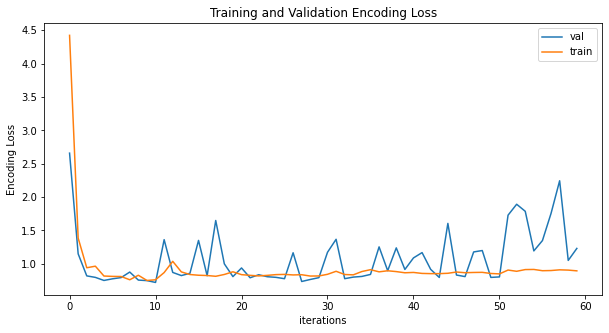

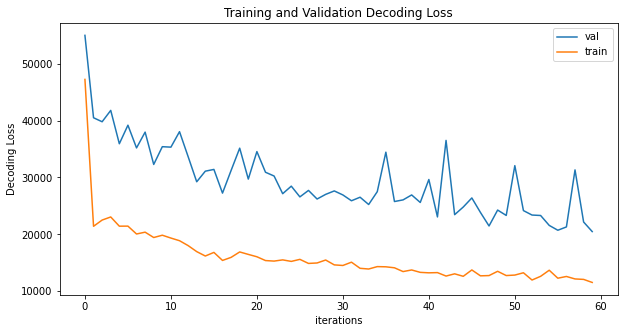

In [18]:
optimizer_enc= optim.Adam(model_wnet.parameters(), lr=0.003)
optimizer_dec= optim.Adam(model_wnet.parameters(), lr=0.004)
epochs = 60
model_wnet = train_wnet(model_wnet, optimizer_enc, optimizer_dec, NCutLoss2D, reconstruction_loss, dataloader, device, valloader = val_dataloader, epochs=epochs)


In [ ]:
# Save Final Model
model_save_name = 'wnet_best.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(model_wnet.state_dict(), path)

## Post Processing

In [19]:
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-vjco4et8
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-vjco4et8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2778808 sha256=13b0f9c4023b14887876b0b17cbf3649ce66aca067cabd220f061f7582f6955b
  Stored in directory: /tmp/pip-ephem-wheel-cache-3o7ru8v0/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf


CRF From Frank Odom https://github.com/fkodom/wnet-unsupervised-image-segmentation/blob/master/src/crf.py

In [20]:
from pydensecrf import densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral


def crf_fit_predict(softmax: np.ndarray, image: np.ndarray, niter: int = 9):
    r"""Fits a Conditional Random Field (CRF) for image segmentation, given a mask of class probabilities (softmax)
    from the WNet CNN and the raw image (image).

    :param softmax: Softmax outputs from a CNN segmentation model.  Shape: (nchan, nrow, ncol)
    :param image: Raw image, containing any number of channels.  Shape: (nchan, nrow, ncol)
    :param niter: Number of iterations during CRF optimization
    :return: Segmented class probabilities -- take argmax to get discrete class labels.
    """
    unary = unary_from_softmax(softmax).reshape(softmax.shape[0], -1)
    bilateral = create_pairwise_bilateral(sdims=(25, 25), schan=(0.05, 0.05), img=image, chdim=0)

    crf = dcrf.DenseCRF2D(image.shape[2], image.shape[1], softmax.shape[0])
    crf.setUnaryEnergy(unary)
    crf.addPairwiseEnergy(bilateral, compat=100)
    pred = crf.inference(niter)

    return np.array(pred).reshape((-1, image.shape[1], image.shape[2]))


def crf_batch_fit_predict(probabilities: np.ndarray, images: np.ndarray, niter: int = 9):
    r"""Fits a Conditional Random Field (CRF) for image segmentation, given a mask of class probabilities (softmax)
    from the WNet CNN and the raw image (image).

    :param probabilities: Softmax outputs from a CNN segmentation model.  Shape: (batch, nchan, nrow, ncol)
    :param images: Raw image, containing any number of channels.  Shape: (batch, nchan, nrow, ncol)
    :param niter: Number of iterations during CRF optimization
    :return: Segmented class probabilities -- take argmax to get discrete class labels.
    """
    return np.stack([crf_fit_predict(p, x, niter) for p, x in zip(probabilities, images)], 0)


## Visualization on the Test Dataset

In [21]:
test_dataset = SegmentationDataset(split="test", preload=True, data_dir=DATASET_PATH, transform=False)
test_dataloader = data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, drop_last=False)

In [29]:
def view_image_wnet(idx):
    img = test_dataset[idx]
    _, axes = plt.subplots(1,5)

    # input
    axes[0].imshow(np.swapaxes(np.swapaxes(img[0], 0, 2), 0, 1))
    axes[0].axis('off')

    # Encoder Output
    result = model_wnet(img[0].unsqueeze(0).cuda(), returns='enc')
    result_np = result.cpu().detach().numpy()
    axes[1].imshow(np.argmax(result_np, axis=1).squeeze())
    axes[1].axis('off')

    # CRF
    result_crf = crf_batch_fit_predict(result_np, img[0].unsqueeze(0).cpu().detach().numpy(), 9)
    axes[2].imshow(np.argmax(result_crf, axis=1).squeeze())
    axes[2].axis('off')

    # Decoder
    result_dec = model_wnet(img[0].unsqueeze(0).cuda(), returns='dec')
    result_dec = result_dec.squeeze(0)
    axes[3].imshow(np.swapaxes(np.swapaxes(result_dec.cpu().detach().numpy(), 0, 2), 0, 1))
    axes[3].axis('off')

    # gt
    axes[4].imshow(img[1][0])
    axes[4].axis('off')

    plt.show()

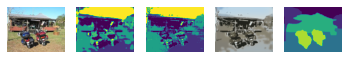

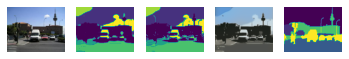

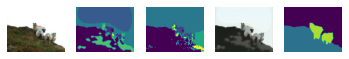

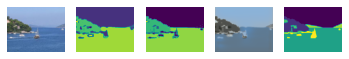

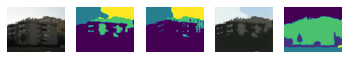

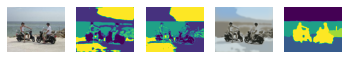

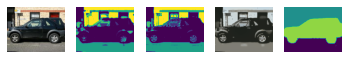

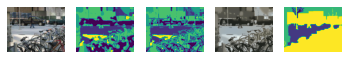

In [30]:
# Example of  prediction
view_image_wnet(0)
view_image_wnet(10)
view_image_wnet(20) 
view_image_wnet(30) 
view_image_wnet(40) 
view_image_wnet(50) 
view_image_wnet(60) 
view_image_wnet(70) 